### 1.11集成学习(Ensemble Methods)
▲集成方法的目的是集合多种基本的预测模型，以提高单一模型的泛化能力和鲁棒性。

▲两种类型的集成方法：

•平均估计：主要原理平均几个独立预测模型的预测结果。通常，该模型主要是以减小方差为目的，因此结合的预测结果比任何一个单一的预测结果都好。比如：Bagging，随机森林等。

•boosting方法：该集成方法主要目的是减少偏差。集合弱学习器生产强学习器。比如：AdaBoost，Gradient TreeBoosting等。

#### 1.11.1 Bagging
•Bagging：训练样本通过整个数据集的抽取-放回-抽取所得。
在减小过拟合方面，bagging方法在集成强大复杂的模型方面表现较好，而boosting方法在集成弱学习器方面表现较好。

单一集成与bagging集成在偏差和方差上的对比

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
# settings
n_repeat = 50
n_train = 50
n_test = 1000
noise = 0.1
np.random.seed(0)
estimators = [("Tree", DecisionTreeRegressor()), 
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]
n_estimators = len(estimators)

In [3]:
# 生产数据
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

In [5]:
X_train = []
y_train = []
for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

In [8]:
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

In [9]:
print(X_test.shape)

(1000, 1)


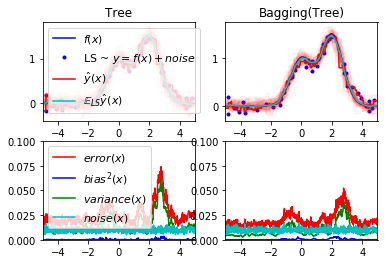

In [11]:
# 循环对学习方法进行比较
for n,(name,estimator) in enumerate(estimators):
    y_predict = np.zeros((n_test,n_repeat))  # 1000*50
    
    for i in range(n_repeat):  #　训练50次
        estimator.fit(X_train[i],y_train[i])
        y_predict[:,i] = estimator.predict(X_test)
        
    y_error = np.zeros(n_test)　# 1000
    
    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:,j]-y_predict[:,i])**2
    
    y_error /= (n_repeat*n_repeat)  # 泛化误差
    
    y_noise = np.var(y_test,axis = 1)  # y_test方差作为噪声
    y_bias = (f(X_test) - np.mean(y_predict,axis = 1)) ** 2  # 偏差
    y_var = np.var(y_predict,axis = 1)  # 方差
    
    plt.subplot(2, n_estimators, n + 1)  # 2 * 2, subplot（１，　２）
    
    plt.plot(X_test, f(X_test), "b", label="$f(x)$") # 绘制蓝色曲线：x_test, f(x_test)，　测试数据
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$") # 绘制蓝色点：训练数据（添加了噪声）
 
    for i in range(n_repeat):  # 绘制红色曲线：测试集的预测结果
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)
 
    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$") 　# 绘制靛色曲线：测试集与预测值的均值
 
    plt.xlim([-5, 5])
    plt.title(name)
 
    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})
 
    plt.subplot(2, n_estimators, n_estimators + n + 1)　# subplot(3, 4)
    plt.plot(X_test, y_error, "r", label="$error(x)$")　# 误差
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),  # 偏差
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),  # 方差
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")  # 噪声   
 
    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])
 
    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})
    